In [51]:
import time
start_time = time.time()

# Introduction to Image Captioning

**Image Captioning** is a fascinating way for computers to describe images using words. Similar to how we glance at a picture and understand what's happening, computers can learn to do the same!

Imagine showing a computer an image of an adorable cat. Image Captioning is like magic that makes the computer say something like, "A fluffy white cat is sitting on a windowsill." It's a beautiful blend of teaching computers to comprehend images and communicate using human-like language.

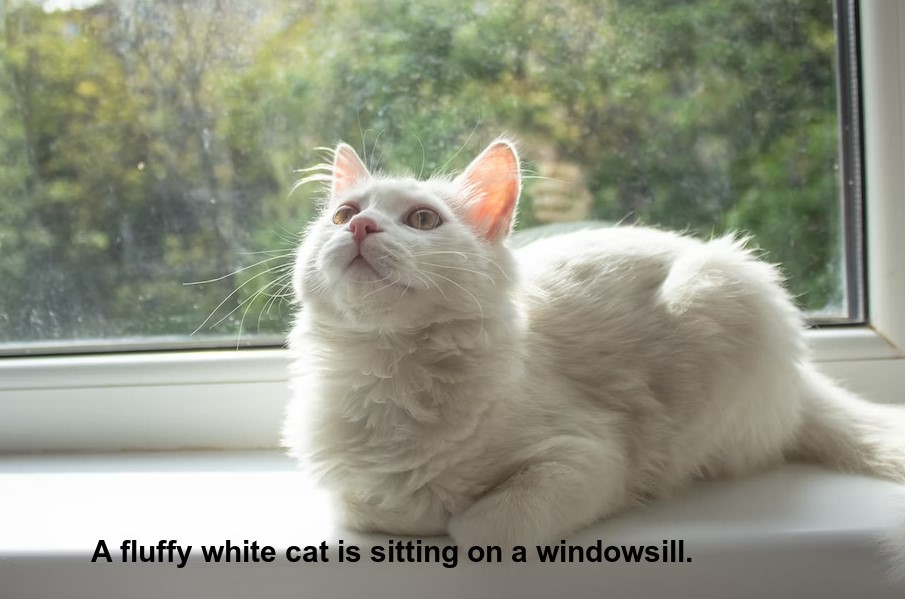

## How It Works

Think of Image Captioning as a collaboration between two essential components of the computer's brain:

1. **The Eye (Convolutional Neural Networks - CNNs):**
   Just as we have eyes to see, computers have CNNs to analyze pictures. These networks help the computer identify important elements in the image, such as the cat's ears or tail. These key elements are translated into a special set of numbers that the computer understands. These special numbers are called "vector embeddings."

2. **The Mouth (Recurrent Neural Networks - RNNs):**
   The computer's "mouth" is the RNN. It takes those special numbers (vector embeddings) from the CNN and combines them with the power of words. It's as if we're teaching the computer to narrate a story about the image. The RNN takes one word at a time and starts forming a sentence. It begins with "Fluffy," followed by "white," and so on, until a complete description is created.

## Why It's Fascinating

Image Captioning empowers computers to describe images just like humans do. This enhances computers' image understanding capabilities and enables them to communicate using descriptive language. If you're curious to see how this collaboration looks in visual representation, check out the Modelling section!


# Import necessary modules

In [52]:
# Basic libraries
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm        # Progress bar library for Jupyter Notebook

# Deep learning framework for building and training models
import tensorflow as tf
## Pre-trained model for image feature extraction
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Tokenizer class for captions tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

## Function for padding sequences to a specific length
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Class for defining Keras models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Lambda

# For checking score
import nltk
# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
from nltk.translate.bleu_score import corpus_bleu

print("All libraries imported successfully!")

All libraries imported successfully!


In [53]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))


2.15.0
True
[]


In [54]:
# Setting the input and output directory
# Create necessary directories for the project
PROJECT_DIR = os.getcwd()  # Current working directory (ICG folder)
INPUT_DIR = os.path.join(PROJECT_DIR, 'data')
OUTPUT_DIR = os.path.join(PROJECT_DIR, 'output')

# Create directories if they don't exist
os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create subdirectories for data
os.makedirs(os.path.join(INPUT_DIR, 'Images'), exist_ok=True)

print(f"Project Directory: {PROJECT_DIR}")
print(f"Input Directory: {INPUT_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")

Project Directory: /home/viethung/anhthu/ICG
Input Directory: /home/viethung/anhthu/ICG/data
Output Directory: /home/viethung/anhthu/ICG/output


# Image Features Extraction

When it comes to understanding images, we need a helping hand from specialized models. Here's where the pre-trained VGG16 model steps in. This model is like a superhero for extracting important details from images, helping us understand what's happening.

![fluffy-cat.jpg](https://www.researchgate.net/publication/353925876/figure/fig2/AS:1057413557915648@1629118446024/Example-of-feature-extraction-using-a-VGG16-A-represents-the-input-layer-of-VGG16-224.ppm)

## Why VGG16?

VGG16 is popular because it has a knack for extracting both simple and complex features from images. Think of it as an image interpreter. It can tell us about the cat's pointy ears, its fluffy fur, and even the windowsill it's sitting on.

With the image features extracted by VGG16, we'll be able to merge the world of images and words, creating meaningful captions that describe the pictures as if the computer were telling a story.

So, let's harness the power of VGG16 for our image feature extraction!

In [55]:
# We are going to use pretrained vgg model
print("Loading VGG16 model...")

# Load the vgg16 model
model = VGG16()
print("✅ VGG16 model loaded successfully!")

# Restructuring the model to remove the last classification layer
# This will give us access to the output features of the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print("✅ Model restructured - removed classification layer")

# Printing the model summary
print("\n📋 Model Summary:")
print(model.summary())

print(f"\n🔧 Model input shape: {model.input_shape}")
print(f"🔧 Model output shape: {model.output_shape}")

Loading VGG16 model...


✅ VGG16 model loaded successfully!
✅ Model restructured - removed classification layer

📋 Model Summary:
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2

In [58]:
# Initialize an empty dictionary to store image features
image_features = {}

# Define the directory path where images are located
img_dir = os.path.join(INPUT_DIR, 'Images')

# Loop through each image in the directory
for img_name in tqdm(os.listdir(img_dir)):
    # Load the image from file
    img_path = os.path.join(img_dir, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # Convert image pixels to a numpy array
    image = img_to_array(image)
    # Reshape the data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess the image for ResNet50
    image = preprocess_input(image)
    # Extract features using the pre-trained ResNet50 model
    image_feature = model.predict(image, verbose=0)
    # Get the image ID by removing the file extension
    image_id = img_name.split('.')[0]
    # Store the extracted feature in the dictionary with the image ID as the key
    image_features[image_id] = image_feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [59]:
# xem thử một vài feature trong image_features
print(f"Total images processed: {len(image_features)}")
for i, (img_id, features) in enumerate(image_features.items()):
    print(f"Image ID: {img_id}, Feature shape: {features.shape}")
    if i >= 2:  # Display only first 3 for brevity
        break


Total images processed: 8091
Image ID: 424506167_01f365726b, Feature shape: (1, 4096)
Image ID: 3000722396_1ae2e976c2, Feature shape: (1, 4096)
Image ID: 3286406057_a1668655af, Feature shape: (1, 4096)


In [60]:
# Store the image features in pickle
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'img_features.pkl'), 'wb'))

In [61]:
# Load features from pickle file
pickle_file_path = os.path.join(OUTPUT_DIR, 'img_features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

# Loading Caption Data

In [62]:
with open(os.path.join(INPUT_DIR, 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [63]:
# Create mapping of image to captions
image_to_captions_mapping = defaultdict(list)

# Process lines from captions_doc
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert captions list to string
    caption = " ".join(captions)
    # Store the caption using defaultdict
    image_to_captions_mapping[image_id].append(caption)

# Print the total number of captions
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

  0%|          | 0/40456 [00:00<?, ?it/s]

Total number of captions: 40455


=== Analyzing image_to_captions_mapping ===
Type: <class 'collections.defaultdict'>
Total number of images: 8091

=== Sample entries ===
Example 1:
  Image ID: 1000268201_693b08cb0e
  Number of captions: 5
  Captions:
    1. A child in a pink dress is climbing up a set of stairs in an entry way .
    2. A girl going into a wooden building .
    3. A little girl climbing into a wooden playhouse .
    4. A little girl climbing the stairs to her playhouse .
    5. A little girl in a pink dress going into a wooden cabin .

Example 2:
  Image ID: 1001773457_577c3a7d70
  Number of captions: 5
  Captions:
    1. A black dog and a spotted dog are fighting
    2. A black dog and a tri-colored dog playing with each other on the road .
    3. A black dog and a white dog with brown spots are staring at each other in the street .
    4. Two dogs of different breeds looking at each other on the road .
    5. Two dogs on pavement moving toward each other .

Example 3:
  Image ID: 1002674143_1b742ab4b

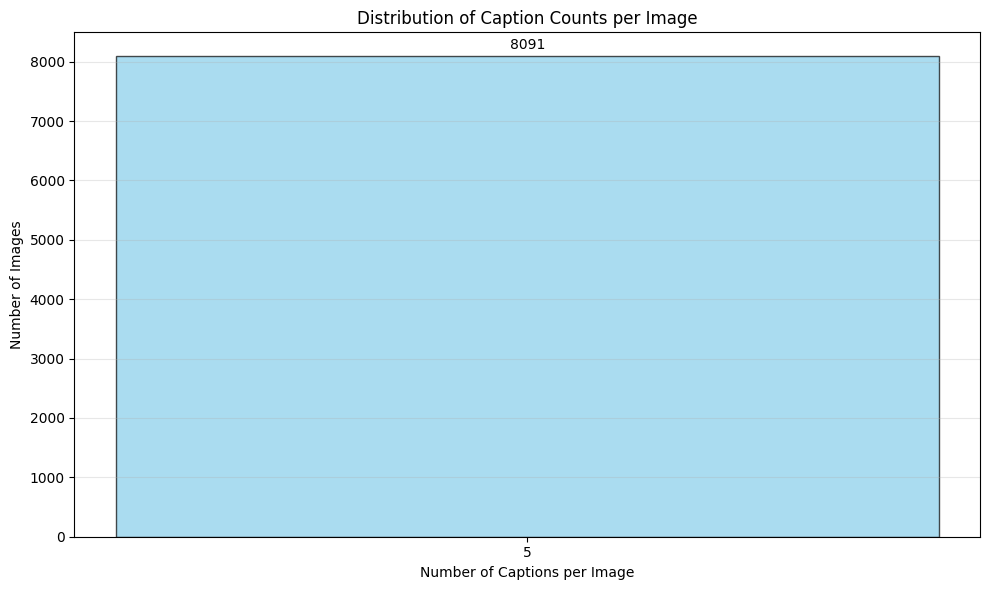

In [64]:
# Let's examine the structure of image_to_captions_mapping
print("=== Analyzing image_to_captions_mapping ===")
print(f"Type: {type(image_to_captions_mapping)}")
print(f"Total number of images: {len(image_to_captions_mapping)}")
print()

# Show some examples
print("=== Sample entries ===")
sample_keys = list(image_to_captions_mapping.keys())[:3]
for i, key in enumerate(sample_keys):
    print(f"Example {i+1}:")
    print(f"  Image ID: {key}")
    print(f"  Number of captions: {len(image_to_captions_mapping[key])}")
    print(f"  Captions:")
    for j, caption in enumerate(image_to_captions_mapping[key]):
        print(f"    {j+1}. {caption}")
    print()

# Statistics
caption_counts = [len(captions) for captions in image_to_captions_mapping.values()]
print("=== Statistics ===")
print(f"Min captions per image: {min(caption_counts)}")
print(f"Max captions per image: {max(caption_counts)}")
print(f"Average captions per image: {sum(caption_counts)/len(caption_counts):.2f}")

# Visualize distribution
import matplotlib.pyplot as plt
from collections import Counter

caption_count_dist = Counter(caption_counts)
print(f"\nCaption count distribution:")
for count, freq in sorted(caption_count_dist.items()):
    print(f"  {count} captions: {freq} images")

# Plot distribution
plt.figure(figsize=(10, 6))
counts, frequencies = zip(*sorted(caption_count_dist.items()))
plt.bar(counts, frequencies, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Number of Captions per Image')
plt.ylabel('Number of Images')
plt.title('Distribution of Caption Counts per Image')
plt.xticks(counts)
plt.grid(axis='y', alpha=0.3)
for i, (count, freq) in enumerate(zip(counts, frequencies)):
    plt.text(count, freq + 0.01*max(frequencies), str(freq), ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [65]:
# Visualize the structure more clearly
print("🔍 DETAILED STRUCTURE ANALYSIS")
print("=" * 50)

# Show it's a defaultdict (which is a type of dict)
print(f"📊 Data Type: {type(image_to_captions_mapping).__name__}")
print(f"📊 Base Type: dict (defaultdict is a subclass of dict)")
print(f"📊 Total Images: {len(image_to_captions_mapping):,}")
print()

# Pick a random image to show structure
import random
random_key = random.choice(list(image_to_captions_mapping.keys()))
print(f"🖼️  EXAMPLE IMAGE: {random_key}")
print(f"📝 Captions for this image:")
for i, caption in enumerate(image_to_captions_mapping[random_key], 1):
    print(f"   {i}. \"{caption}\"")
print()

# Show the key-value structure
print("🗂️  STRUCTURE VISUALIZATION:")
print("image_to_captions_mapping = {")
sample_items = list(image_to_captions_mapping.items())[:2]
for img_id, captions in sample_items:
    print(f"    '{img_id}': [")
    for caption in captions:
        print(f"        '{caption}',")
    print(f"    ],")
print("    ... (and so on for all images)")
print("}")
print()

# Show some statistics about caption lengths
all_captions_flat = []
for captions in image_to_captions_mapping.values():
    all_captions_flat.extend(captions)

caption_lengths = [len(caption.split()) for caption in all_captions_flat]
print("📏 CAPTION LENGTH STATISTICS:")
print(f"   Shortest caption: {min(caption_lengths)} words")
print(f"   Longest caption: {max(caption_lengths)} words")
print(f"   Average length: {sum(caption_lengths)/len(caption_lengths):.2f} words")

# Show some examples of different length captions
print(f"\n📖 CAPTION LENGTH EXAMPLES:")
short_captions = [c for c in all_captions_flat if len(c.split()) <= 5]
long_captions = [c for c in all_captions_flat if len(c.split()) >= 15]

if short_captions:
    print(f"   Short caption example: \"{random.choice(short_captions)}\"")
if long_captions:
    print(f"   Long caption example: \"{random.choice(long_captions)}\"")

🔍 DETAILED STRUCTURE ANALYSIS
📊 Data Type: defaultdict
📊 Base Type: dict (defaultdict is a subclass of dict)
📊 Total Images: 8,091

🖼️  EXAMPLE IMAGE: 3029463004_c2d2c8f404
📝 Captions for this image:
   1. "A male surfer is on his stomach and riding a wave ."
   2. "A man on a blue surfboard is on a wave ."
   3. "A surfboarder prepares to catch a wave ."
   4. "A surfer rides the waves ."
   5. "Person riding wave on stomach on a blue surfboard ."

🗂️  STRUCTURE VISUALIZATION:
image_to_captions_mapping = {
    '1000268201_693b08cb0e': [
        'A child in a pink dress is climbing up a set of stairs in an entry way .',
        'A girl going into a wooden building .',
        'A little girl climbing into a wooden playhouse .',
        'A little girl climbing the stairs to her playhouse .',
        'A little girl in a pink dress going into a wooden cabin .',
    ],
    '1001773457_577c3a7d70': [
        'A black dog and a spotted dog are fighting',
        'A black dog and a tri-colored

📏 CAPTION LENGTH STATISTICS:
   Shortest caption: 1 words
   Longest caption: 37 words
   Average length: 11.70 words

📖 CAPTION LENGTH EXAMPLES:
   Short caption example: "Two girls hugging ."
   Long caption example: "A child in a jeans jacket and shorts holding up a white dress as another darker-skinned child looks at it ."


#### So there are total 40455 captions for 8091 images that's means there are 5 captions for each image

# Preprocessing Captions: Getting Them Ready

Before we dive into the exciting world of creating captions for images, we need to prepare our captions so that our models can understand them. This process is known as preprocessing.

In [66]:
# Function for processing the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetical characters
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            # Remove extra spaces
            caption = caption.replace('\s+', ' ')
            # Add unique start and end tokens to the caption
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [67]:
# before preprocess of text
image_to_captions_mapping['1026685415_0431cbf574']

['A black dog carries a green toy in his mouth as he walks through the grass .',
 'A black dog carrying something through the grass .',
 'A black dog has a blue toy in its mouth .',
 'A dog in grass with a blue item in his mouth .',
 'A wet black dog is carrying a green toy through the grass .']

In [68]:
# preprocess the text
clean(image_to_captions_mapping)

In [69]:
# after preprocess of text
image_to_captions_mapping['1026685415_0431cbf574']

['startseq black dog carries green toy in his mouth as he walks through the grass endseq',
 'startseq black dog carrying something through the grass endseq',
 'startseq black dog has blue toy in its mouth endseq',
 'startseq dog in grass with blue item in his mouth endseq',
 'startseq wet black dog is carrying green toy through the grass endseq']

In [70]:
# Creating a List of All Captions
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

In [71]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [72]:
# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [73]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [74]:
# Calculate maximum caption length
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Print the results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 8768
Maximum Caption Length: 34


# Train Test Split

In [75]:
# Creating a List of Image IDs
image_ids = list(image_to_captions_mapping.keys())
# Splitting into Training and Test Sets
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [76]:
# Data generator function
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    # Lists to store batch data
    X1_batch, X2_batch, y_batch = [], [], []
    # Counter for the current batch size
    batch_count = 0

    while True:
        # Loop through each image in the current batch
        for image_id in data_keys: 
            # Get the captions associated with the current image
            captions = image_to_captions_mapping[image_id]

            # Loop through each caption for the current image
            for caption in captions:
                # Convert the caption to a sequence of token IDs
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                # Loop through the tokens in the caption sequence
                for i in range(1, len(caption_seq)):
                    # Split the sequence into input and output pairs
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    # Pad the input sequence to the specified maximum caption length
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]

                    # Convert the output sequence to one-hot encoded format
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append data to batch lists
                    X1_batch.append(features[image_id][0])  # Image features
                    X2_batch.append(in_seq)  # Input sequence
                    y_batch.append(out_seq)  # Output sequence

                    # Increase the batch counter
                    batch_count += 1

                    # If the batch is complete, yield the batch and reset lists and counter
                    if batch_count == batch_size:
                        X1_batch, X2_batch, y_batch = np.array(X1_batch), np.array(X2_batch), np.array(y_batch)
                        yield [X1_batch, X2_batch], y_batch
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

# LSTM Model Training

We've got our image features, and we're ready to make our captions come to life. In this section, we'll be diving into the training of our LSTM model. This is where the real magic happens as we teach our model to generate descriptive captions for our images.

![LSTM-Architecture](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

In [77]:
# Encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

# Sequence feature layers
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

# Apply attention mechanism using Dot product
attention = Dot(axes=[2, 2])([fe2_projected, se3])  # Calculate attention scores

# Softmax attention scores
attention_scores = Activation('softmax')(attention)

# Apply attention scores to sequence embeddings
attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])

# Sum the attended sequence embeddings along the time axis
context_vector = tf.reduce_sum(attention_context, axis=1)

# Decoder model
decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Create the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Visualize the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [78]:
# Set the number of epochs, batch size
epochs = 50
batch_size = 32

# Calculate the steps_per_epoch based on the number of batches in one epoch
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)  # Calculate the steps for validation data

# Loop through the epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Set up data generators
    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    
    model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
          validation_data=test_generator, validation_steps=validation_steps,
          verbose=1)

Epoch 1/50


W0000 00:00:1760158848.076364  401607 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2496 num_cores: 20 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 25165824 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


228/228 [==============================] - ETA: 0s - loss: 6.3767

W0000 00:00:1760158867.733072  401607 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2496 num_cores: 20 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 25165824 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


228/228 [==============================] - 24s 87ms/step - loss: 6.3767 - val_loss: 6.4863
Epoch 2/50
228/228 [==============================] - 19s 83ms/step - loss: 5.2009 - val_loss: 6.1958
Epoch 3/50
228/228 [==============================] - 19s 83ms/step - loss: 4.7850 - val_loss: 6.1804
Epoch 4/50
228/228 [==============================] - 19s 83ms/step - loss: 4.4181 - val_loss: 6.3601
Epoch 5/50
228/228 [==============================] - 20s 90ms/step - loss: 4.1317 - val_loss: 6.5410
Epoch 6/50
228/228 [==============================] - 19s 84ms/step - loss: 3.8512 - val_loss: 6.5311
Epoch 7/50
228/228 [==============================] - 19s 84ms/step - loss: 3.5459 - val_loss: 6.7183
Epoch 8/50
228/228 [==============================] - 21s 92ms/step - loss: 3.2319 - val_loss: 7.6533
Epoch 9/50
228/228 [==============================] - 19s 84ms/step - loss: 3.0738 - val_loss: 7.4151
Epoch 10/50
228/228 [==============================] - 20s 86ms/step - loss: 2.8008 - val_los

In [79]:
# Save the model
model.save(OUTPUT_DIR+'/mymodel.h5')

# Captions Generation

In [80]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [81]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    # Initialize the caption sequence
    caption = 'startseq'
    
    # Generate the caption
    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence to match the maximum caption length
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        # Predict the next word's probability distribution
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get the index with the highest probability
        predicted_index = np.argmax(yhat)
        # Convert the index to a word
        predicted_word = get_word_from_index(predicted_index, tokenizer)
        
        # Append the predicted word to the caption
        caption += " " + predicted_word
        
        # Stop if the word is None or if the end sequence tag is encountered
        if predicted_word is None or predicted_word == 'endseq':
            break
    
    return caption

In [82]:
# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for key in tqdm(test):
    # Get actual captions for the current image
    actual_captions = image_to_captions_mapping[key]
    # Predict the caption for the image using the model
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)
    
    # Split actual captions into words
    actual_captions_words = [caption.split() for caption in actual_captions]
    # Split predicted caption into words
    predicted_caption_words = predicted_caption.split()
    
    # Append to the lists
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

W0000 00:00:1760159829.479636  401607 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2496 num_cores: 20 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 25165824 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


BLEU-1: 0.423362
BLEU-2: 0.188136


# Predicting captions for Images

In [83]:
# Function for generating caption
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq couple stands close at the water edge endseq
startseq the two people stand by body of water and in front of bushes in fall endseq
startseq two people hold each other near pond endseq
startseq two people stand by the water endseq
startseq two people stand together on the edge of the water on the grass endseq


--------------------Predicted--------------------
startseq three people are on the edge of lake in the water and the jumps in the water and the her him is it in the water endseq


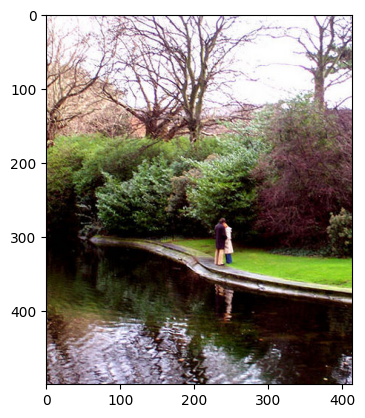

In [84]:
generate_caption("3637013_c675de7705.jpg")

---------------------Actual---------------------
startseq boy in blue shorts slides down slide into pool endseq
startseq boy in blue swimming trunks slides down yellow slide into wading pool with inflatable toys floating in the water endseq
startseq boy rides down slide into small backyard pool endseq
startseq boy sliding down slide into pool with colorful tubes endseq
startseq child is falling off slide onto colored balloons floating on pool of water endseq
--------------------Predicted--------------------
startseq boy is falling off slide onto colored balloons floating on pool of water endseq
--------------------Predicted--------------------
startseq boy is falling off slide onto colored balloons floating on pool of water endseq


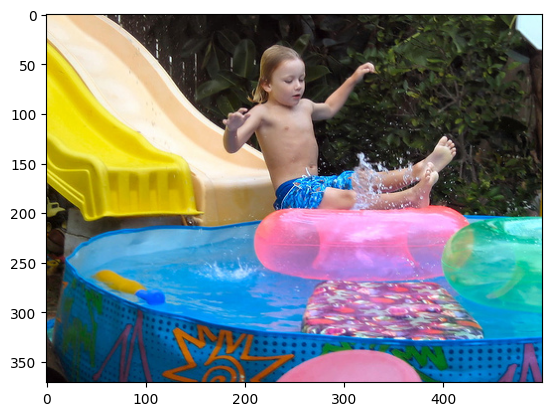

In [85]:
generate_caption("1077546505_a4f6c4daa9.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl is sitting in front of large painted rainbow with her hands in bowl endseq
--------------------Predicted--------------------
startseq little girl is sitting in front of large painted rainbow with her hands in bowl endseq


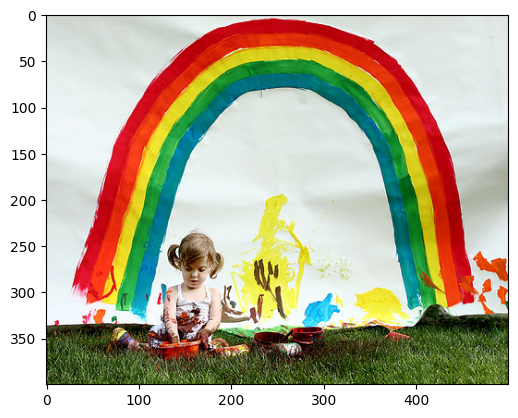

In [86]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq woman crouches near three dogs in field endseq
startseq three dogs are playing on grassy hill with blue sky endseq
startseq three dogs are standing in the grass and person is sitting next to them endseq
startseq three dogs on grassy hill endseq
startseq three dogs stand in grassy field while person kneels nearby endseq
--------------------Predicted--------------------
startseq three dogs are playing on grassy hill with blue sky endseq
--------------------Predicted--------------------
startseq three dogs are playing on grassy hill with blue sky endseq


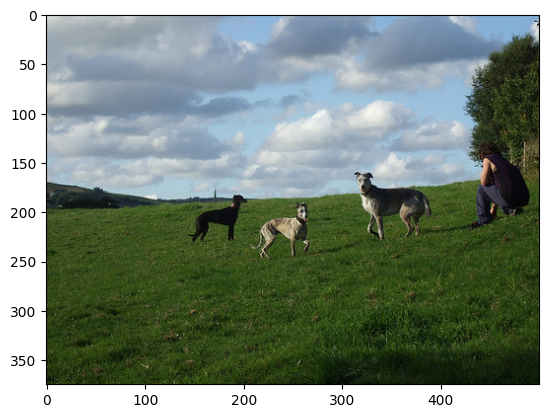

In [88]:
generate_caption("1032122270_ea6f0beedb.jpg")

In [89]:
end_time = time.time()
elapsed = end_time - start_time
print(f"Total runtime for image-captioner.ipynb: {elapsed/60:.2f} minutes ({elapsed:.2f} seconds)")


Total runtime for image-captioner.ipynb: 44.93 minutes (2696.07 seconds)
